In [3]:
import os

os.chdir('c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII')
os.getcwd()


'c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

og=pd.read_csv('data/processed/cleaned_bwi.csv')
og.head()

#df['DateTime'] = pd.to_datetime(df['DateTime'])

,DateTime,Flow_MGD,Meter,Source_File,QC_flag,Flow_MGD_BWI_Corrected
0,2023-01-01 12:00:00,1.496,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.766133
1,2023-01-01 12:15:00,1.505,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.775133
2,2023-01-01 12:30:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.786133
3,2023-01-01 12:45:00,1.547,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.817133
4,2023-01-01 13:00:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.786133


In [33]:
# MAIN ALGORITHM OUTLINE
import holidays
import pandas as pd
import numpy as np  
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')




def detect_wet_dry_periods(df, k=2.5,sigma_method='robust', max_iterations=50, threshold=0.05):
    """
    Iterative anomaly detection for I/I identification
    """
    
    # 1. INITIALIZE
    training_data = df[['DateTime', 'Flow_MGD_BWI_Corrected']].copy()

    training_data['DateTime'] = pd.to_datetime(training_data['DateTime'])
    
    training_data.rename(columns={
            'DateTime': 'ds',
            'Flow_MGD_BWI_Corrected': 'y'
        }, inplace=True)
    
    training_data = training_data.dropna()
    original_data = training_data.copy()

    ds_min = training_data['ds'].min()
    ds_max = training_data['ds'].max()

    # ensure min/max are valid datetimes
    if pd.isna(ds_min) or pd.isna(ds_max):
        raise ValueError("DateTime column contains NaT values.")

    us_holidays = holidays.US(years=range(ds_min.year, ds_max.year + 1))


    holiday_df = pd.DataFrame({
        'ds': pd.to_datetime(list(us_holidays.keys())),
        'holiday': list(us_holidays.values())
    })

    # Track iterations for visualization
    iteration_history = []
    previous_forecast = None

    iteration = 0
    
    while iteration < max_iterations:
        print(f"\nIteration {iteration + 1}:")

        # 2. TRAIN BWF RECONSTRUCTION MODEL (Prophet

        if iteration <= 1:
            fit_data = training_data.set_index('ds').resample('D').sum().reset_index().dropna()
            daily_seasonality = False
        elif iteration <= 4:
            fit_data = training_data.set_index('ds').resample('1h').mean().reset_index().dropna()
            daily_seasonality = True
        else:
            fit_data = training_data  # full resolution for final fit only
        
        model = Prophet(
            # Trend component (piecewise linear)
            growth='linear',
            changepoint_prior_scale=0.05,
            yearly_seasonality=6,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=holiday_df
        )

        model.fit(fit_data, iter=200)
        
        #model.fit(training_data,iter=200)


        # 3. CALCULATE RESIDUALS (on training data only)
        # potentially revisit
        # Predict at fit_data resolution for residual calculation
        fit_forecast = model.predict(fit_data[['ds']])
        residuals = fit_data['y'].values - fit_forecast['yhat'].values

        # Predict on ORIGINAL data (not just training data)
        forecast = model.predict(original_data[['ds']])
        
        if sigma_method == 'standard':
            mu = residuals.mean()
            sigma = residuals.std()

        
        elif sigma_method == 'robust':
            mu = np.median(residuals)
            sigma = 1.4826 * np.median(np.abs(residuals - mu))
            
            if sigma == 0:
                sigma = np.std(residuals)
                print(f"  Residual stats: μ={mu:.4f}, σ={sigma:.4f}")

        
        # 4. ANOMALY DETECTION (k-sigma rule)
        lower_bound = mu - k * sigma
        upper_bound = mu + k * sigma
        anomalies = (residuals < lower_bound) | (residuals > upper_bound)
        n_anomalies = anomalies.sum()
        print(f"  Anomalies detected: {n_anomalies} ({100*n_anomalies/len(training_data):.1f}%)")

        # Store iteration info
        iteration_history.append({
            'iteration': iteration,
            'forecast': forecast.copy(),
            'n_points': len(training_data),
            'n_anomalies': n_anomalies,
            'mu': mu,
            'sigma': sigma,
            'bounds': (lower_bound, upper_bound)
        })

        # 5. CHECK TERMINATION CONDITIONS
        should_terminate, reason = check_termination(
            residuals, forecast, previous_forecast, threshold
        )
        
        if should_terminate:
            print(f"\nTerminating: {reason}")
            break
        
        if n_anomalies == 0:
            print("\nTerminating: No more anomalies detected")
            break

        # 6. REMOVE ANOMALIES FOR NEXT ITERATION
        if iteration <= 2:
            # anomalies are indexed against daily fit_data
            # must map back to 15-min training_data by date
            anomalous_dates = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.date.isin(anomalous_dates.dt.date)]
        elif iteration <= 4:
            # anomalies are indexed against hourly fit_data
            # map back to 15-min training_data by hour
            anomalous_hours = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.floor('1h').isin(anomalous_hours)]
        else:
            # anomalies are indexed directly against 15-min training_data
            training_data = training_data.loc[~anomalies]
        
        previous_forecast = forecast
        iteration += 1



    
    print(f"\nCompleted after {iteration + 1} iterations")
    
    # 7. FINAL ANOMALY CLASSIFICATION on all original data
    final_forecast = iteration_history[-1]['forecast']
    final_residuals = original_data['y'].values - final_forecast['yhat'].values
    final_mu = iteration_history[-1]['mu']
    final_sigma = iteration_history[-1]['sigma']
    final_lower = final_mu - k * final_sigma
    final_upper = final_mu + k * final_sigma
    
    anomaly_labels = (final_residuals < final_lower) | (final_residuals > final_upper)
    
    # 8. ISOLATED POINT REMOVAL
    anomaly_labels_cleaned = remove_isolated_points(anomaly_labels.astype(np.bool_), window_size=12)

    
    print(f"\nFinal classification:")
    print(f"  Anomalous points: {anomaly_labels_cleaned.sum()} ({100*anomaly_labels_cleaned.sum()/len(anomaly_labels_cleaned):.1f}%)")
    print(f"  Normal points: {(~anomaly_labels_cleaned).sum()} ({100*(~anomaly_labels_cleaned).sum()/len(anomaly_labels_cleaned):.1f}%)")
    
    # 9. CALCULATE RESIDUAL FLOW (anomalous deviation from forecast)
    residual_flow = original_data['y'].values - final_forecast['yhat'].values
    residual_flow[~anomaly_labels_cleaned] = 0  # Zero out non-anomalous points
    
    return {
        'anomaly_labels': anomaly_labels_cleaned,
        'residual_flow': residual_flow,
        'forecast': final_forecast,
        'original_data': original_data,
        'iteration_history': iteration_history,
        'final_bounds': (final_lower, final_upper),
        'k':k
    }



def check_termination(residuals, current_forecast, previous_forecast, threshold):
    """
    Check if any termination condition is met

    """
    
    # Condition 1: Normality test (Anderson-Darling)
    result = stats.anderson(residuals, dist='norm')
    # If statistic < critical value, data is normal
    if result.statistic < result.critical_values[2]:  # 5% significance
        return True, "Residuals pass normality test"
    
    # Condition 2: Maximum residual threshold
    max_abs_residual = np.abs(residuals).max()
    if max_abs_residual < threshold:
        return True, f"Max residual ({max_abs_residual:.4f}) below threshold ({threshold})"
    
    # Condition 3: High correlation between successive forecasts
    if previous_forecast is not None:
        correlation, _ = pearsonr(
            current_forecast['yhat'].values,
            previous_forecast['yhat'].values
        )
        if correlation > 0.999:
            return True, f"High correlation ({correlation:.6f}) between successive forecasts"
    
    return False, None


def remove_isolated_points(labels, window_size=12):
    n = len(labels)
    cleaned = np.empty(n, dtype=bool)
    half = window_size // 2
    for i in range(n):
        start = max(0, i - half)
        end = min(n, i + half + 1)
        count_true = 0
        for j in range(start, end):
            if labels[j]:
                count_true += 1
        if count_true > (end - start) / 2:
            cleaned[i] = True
        else:
            cleaned[i] = False
    return cleaned




In [5]:
CBO=og[og['Meter']=="CBO"]
CBO.head(2)
CBO.dtypes

DateTime                   object
Flow_MGD                  float64
Meter                      object
Source_File                object
QC_flag                    object
Flow_MGD_BWI_Corrected    float64
dtype: object

In [34]:
# Run the detection
robust_results = detect_wet_dry_periods(
    CBO,
    k=2.2,
    sigma_method='robust',
    max_iterations=5,
    threshold=0.5
)


19:51:14 - cmdstanpy - INFO - Chain [1] start processing



Iteration 1:


19:51:14 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 137 (0.1%)

Iteration 2:


19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:51:27 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 202 (0.2%)

Iteration 3:


19:51:39 - cmdstanpy - INFO - Chain [1] start processing
19:51:41 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 1502 (1.8%)

Iteration 4:


19:51:55 - cmdstanpy - INFO - Chain [1] start processing
19:51:56 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 448 (0.8%)

Terminating: Max residual (0.2666) below threshold (0.5)

Completed after 4 iterations

Final classification:
  Anomalous points: 26634 (26.8%)
  Normal points: 72797 (73.2%)


In [8]:
# Run the detection
standard_results = detect_wet_dry_periods(
    CBO,
    k=2.2,
    sigma_method='standard',
    max_iterations=5,
    threshold=0.5
)



19:01:41 - cmdstanpy - INFO - Chain [1] start processing



Iteration 1:


19:01:41 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 42 (0.0%)

Iteration 2:


19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 90 (0.1%)

Iteration 3:


19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 847 (0.9%)

Iteration 4:


19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 745 (1.0%)

Iteration 5:


19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:40 - cmdstanpy - INFO - Chain [1] done processing


  Anomalies detected: 646 (0.9%)

Terminating: Max residual (0.2981) below threshold (0.5)

Completed after 5 iterations

Final classification:
  Anomalous points: 20987 (21.1%)
  Normal points: 78444 (78.9%)


In [10]:
removed_standard = standard_results['anomaly_labels'].sum()
removed_robust   = robust_results['anomaly_labels'].sum()

print(f"Standard deviation method removed {removed_standard} points ({100*removed_standard/len(CBO):.1f}%)")
print(f"Robust method removed {removed_robust} points ({100*removed_robust/len(CBO):.1f}%)")

Standard deviation method removed 20987 points (19.9%)
Robust method removed 26634 points (25.3%)


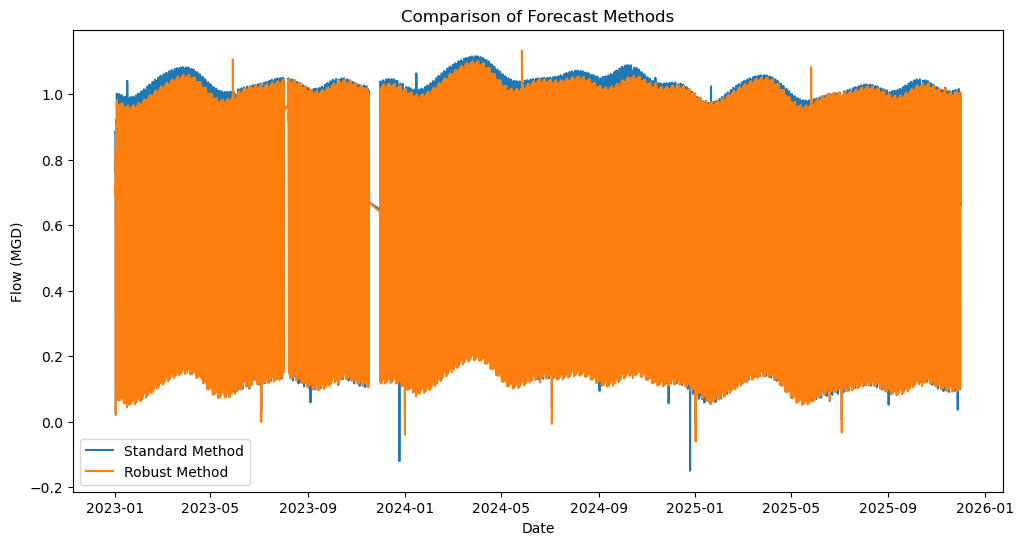

In [13]:


plt.figure(figsize=(12, 6))
plt.plot(standard_results['forecast']['ds'], standard_results['forecast']['yhat'], label='Standard Method')
plt.plot(robust_results['forecast']['ds'], robust_results['forecast']['yhat'], label='Robust Method')
plt.xlabel('Date')
plt.ylabel('Flow (MGD)')
plt.title('Comparison of Forecast Methods')
plt.legend()
plt.show()

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def plot_final_classification(results):
    """
    Plot the final anomaly classification with forecast and anomaly labels.
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    
    k=results['k']
    original = results['original_data']
    anomaly_labels = results['anomaly_labels']
    final_forecast = results['forecast']
    bounds = results['final_bounds']
    
    # Plot normal points
    normal_mask = ~anomaly_labels
    ax.plot(original['ds'][normal_mask], original['y'][normal_mask], 'o',
            color='blue', alpha=0.5, markersize=3, label='Normal')
    
    # Plot anomalous points
    anomaly_mask = anomaly_labels
    ax.plot(original['ds'][anomaly_mask], original['y'][anomaly_mask], 'o',
            color='red', alpha=0.5, markersize=3, label='Anomaly')
    
    # Plot final forecast
    ax.plot(final_forecast['ds'], final_forecast['yhat'],
            linewidth=2, color='darkblue', label='Forecast', zorder=5)
    
    # Plot confidence bounds
    ax.fill_between(final_forecast['ds'],
                    final_forecast['yhat'] + bounds[0],
                    final_forecast['yhat'] + bounds[1],
                    alpha=0.2, color='blue', label=f'{k}σ Bounds')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Flow (MGD)', fontsize=12)
    ax.set_title('Final Anomaly Classification', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_final_classification.png', dpi=300, bbox_inches='tight')
    plt.show()



def plot_iteration_statistics(results):
    """
    Plot iteration statistics: training data reduction, anomalies removed,
    residual std deviation, and residual mean convergence.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    history = results['iteration_history']
    iterations = [h['iteration'] + 1 for h in history]
    n_points = [h['n_points'] for h in history]
    n_anomalies = [h['n_anomalies'] for h in history]
    sigmas = [h['sigma'] for h in history]
    mus = [h['mu'] for h in history]
    
    # Training points remaining
    axes[0, 0].plot(iterations, n_points, 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Training Points Remaining')
    axes[0, 0].set_title('Training Data Reduction')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Anomalies removed per iteration (with secondary y-axis for %)
    bars = axes[0, 1].bar(iterations, n_anomalies, color='coral', alpha=0.7)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Anomalies Detected')
    axes[0, 1].set_title('Anomalies Removed Per Iteration')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Calculate percentage anomalies detected relative to points at each iteration
    percent_anomalies = [(n_anomalies[i] / n_points[i]) * 100 if n_points[i] > 0 else 0 for i in range(len(n_points))]
    
    # Annotate percentage above bars
    for rect, pct in zip(bars, percent_anomalies):
        height = rect.get_height()
        axes[0, 1].annotate(f'{pct:.1f}%', 
                            xy=(rect.get_x() + rect.get_width() / 2, height), 
                            xytext=(0, 5),  # 5 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=9,
                            color='darkred',
                            fontweight='bold')
    
    ax2 = axes[0, 1].twinx()  # Create secondary y-axis
    ax2.set_ylabel('% Anomalies Detected', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    ax2.set_ylim(0, max(percent_anomalies)*1.2 if percent_anomalies else 10)  # Add some padding on top
    
    ax2.legend(loc='upper right', fontsize=9)
    
    # Residual standard deviation
    axes[1, 0].plot(iterations, sigmas, 's-', linewidth=2, markersize=8, color='green')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Standard Deviation (σ)')
    axes[1, 0].set_title('Residual Standard Deviation')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    # Residual mean convergence
    axes[1, 1].plot(iterations, mus, 'd-', linewidth=2, markersize=8, color='purple')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Mean Residual (μ)')
    axes[1, 1].set_title('Residual Mean Convergence')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Whole number x-axis
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_average_diurnal_pattern_all(results):
    """
    Plot the average diurnal pattern for:
    - Forecasted baseline
    - Non-anomalous points
    - All observed points
    
    - results: output from detect_wet_dry_periods
    """
    import matplotlib.pyplot as plt
    
    # Extract data
    original = results['original_data'].copy()
    forecast = results['forecast'].copy()
    anomaly_labels = results['anomaly_labels']
    
    # Add 'hour' column
    original['hour'] = original['ds'].dt.hour
    forecast['hour'] = forecast['ds'].dt.hour
    
    # Non-anomalous points
    normal_data = original[~anomaly_labels]
    
    # Compute average flow per hour
    avg_all = original.groupby('hour')['y'].mean()
    avg_normal = normal_data.groupby('hour')['y'].mean()
    avg_forecast = forecast.groupby('hour')['yhat'].mean()
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(avg_forecast.index, avg_forecast.values, 'o-', color='darkblue', linewidth=2, label='Forecast (Baseline)')
    plt.plot(avg_normal.index, avg_normal.values, 's-', color='orange', linewidth=2, label='Non-Anomalous Observed')
    plt.plot(avg_all.index, avg_all.values, 'd--', color='green', linewidth=2, label='All Observed Points')
    
    plt.xticks(range(0,24))
    plt.xlabel('Hour of Day')
    plt.ylabel('Flow (MGD)')
    plt.title('Average Diurnal Flow Pattern')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('average_diurnal_pattern_all_points.png', dpi=300, bbox_inches='tight')
    plt.show()


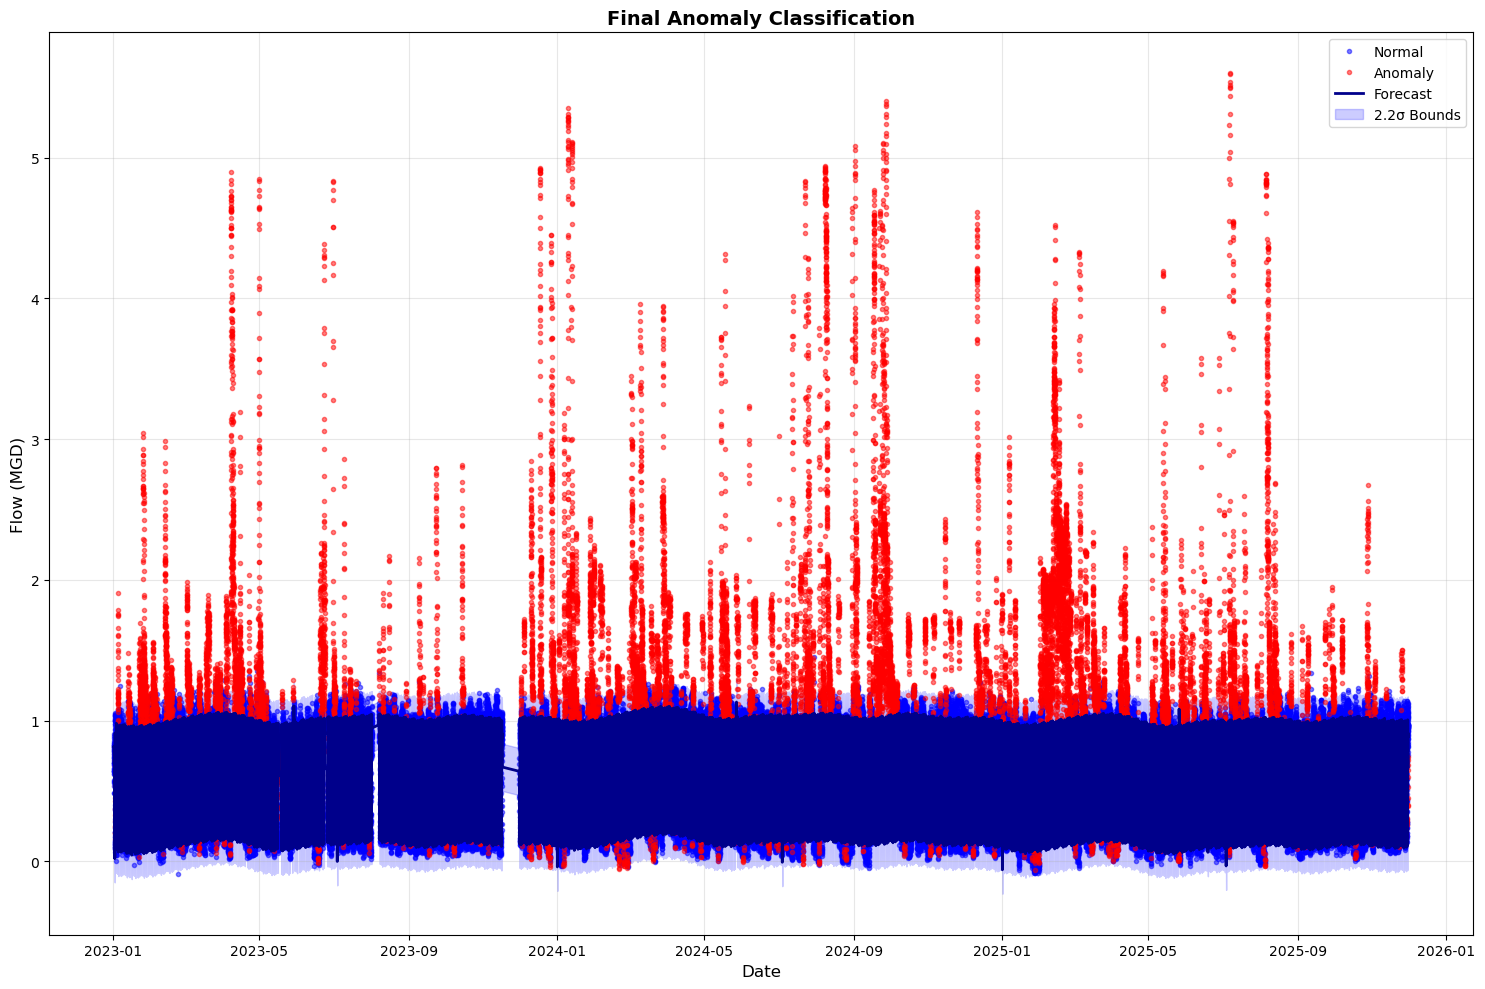

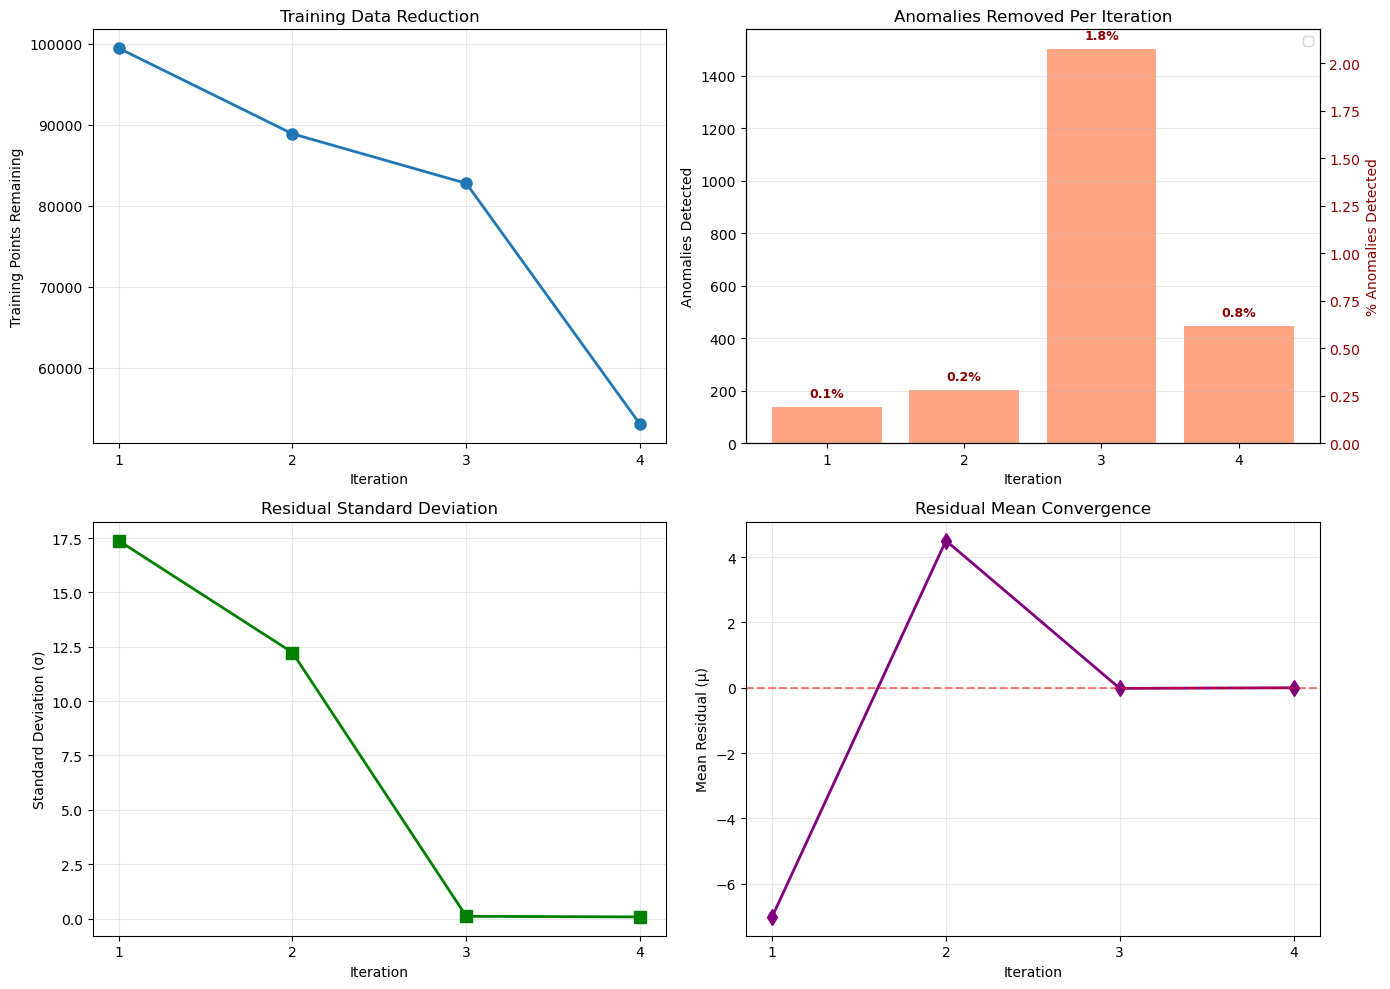

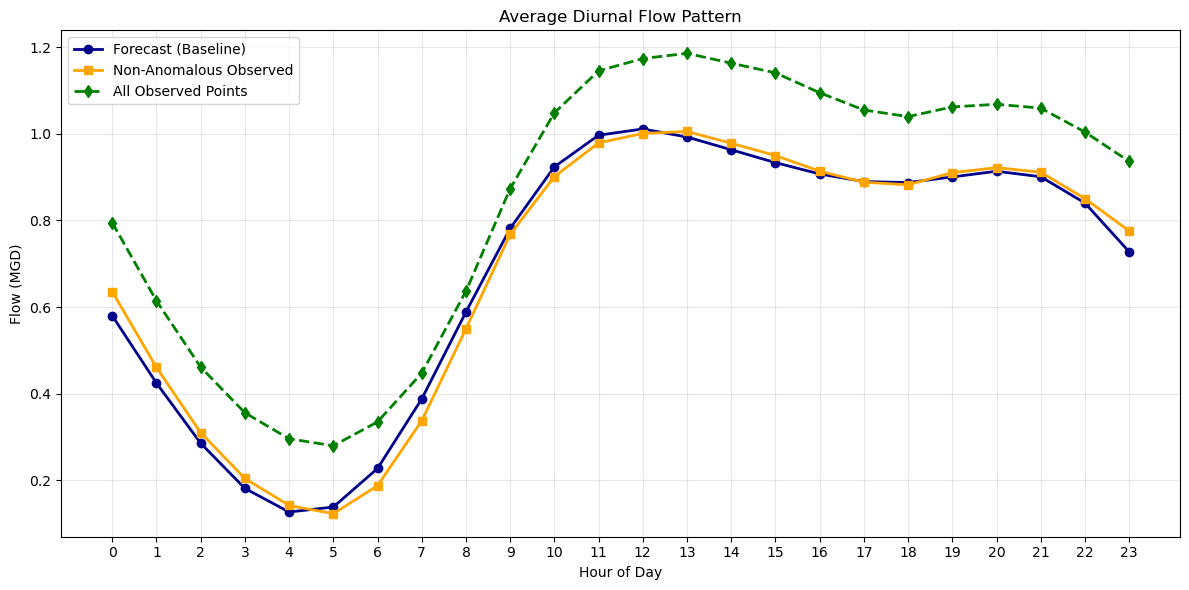

In [37]:
plot_final_classification(robust_results)
plot_iteration_statistics(robust_results)
plot_average_diurnal_pattern_all(robust_results)